In [51]:
import pandas as pd
import requests
import numpy as np
import requests
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
content= requests.get("https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol=IBM&interval=5min&apikey=demo").json()
content

{'Meta Data': {'1. Information': 'Intraday (5min) open, high, low, close prices and volume',
  '2. Symbol': 'IBM',
  '3. Last Refreshed': '2022-12-16 19:15:00',
  '4. Interval': '5min',
  '5. Output Size': 'Compact',
  '6. Time Zone': 'US/Eastern'},
 'Time Series (5min)': {'2022-12-16 19:15:00': {'1. open': '140.0600',
   '2. high': '140.0600',
   '3. low': '140.0600',
   '4. close': '140.0600',
   '5. volume': '155'},
  '2022-12-16 18:20:00': {'1. open': '140.1600',
   '2. high': '140.1600',
   '3. low': '140.1600',
   '4. close': '140.1600',
   '5. volume': '1499'},
  '2022-12-16 18:15:00': {'1. open': '140.1500',
   '2. high': '140.1600',
   '3. low': '140.1500',
   '4. close': '140.1600',
   '5. volume': '2501'},
  '2022-12-16 18:10:00': {'1. open': '139.9900',
   '2. high': '140.0000',
   '3. low': '139.9900',
   '4. close': '140.0000',
   '5. volume': '208'},
  '2022-12-16 17:10:00': {'1. open': '139.8811',
   '2. high': '139.8811',
   '3. low': '139.8811',
   '4. close': '139.88

In [39]:
symbol = 'IBM'
df = yf.download(symbol, start='2022-12-16', interval='5m')

[*********************100%***********************]  1 of 1 completed


In [43]:
df.head(3)

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2022-12-16 09:30:00,141.250000,141.914993,140.860001,141.464996,141.464996,1077483
2022-12-16 09:35:00,141.464996,141.750000,141.259995,141.369995,141.369995,47815
2022-12-16 09:40:00,141.350006,141.539993,141.089996,141.470001,141.470001,51660


In [13]:
df.head(3)

,time,open,high,low,close,volume
1,2022-12-16 19:15:00,140.06,140.06,140.06,140.06,155
2,2022-12-16 18:30:00,140.16,140.16,140.16,140.16,1499
3,2022-12-16 18:15:00,139.99,140.16,139.99,140.16,2709


In [45]:
def Supertrend(df, atr_period, multiplier):
    
    high = df['High']
    low = df['Low']
    close = df['Close']
    
    # calculate ATR
    price_diffs = [high - low, 
                   high - close.shift(), 
                   close.shift() - low]
    true_range = pd.concat(price_diffs, axis=1)
    true_range = true_range.abs().max(axis=1)
    # default ATR calculation in supertrend indicator
    atr = true_range.ewm(alpha=1/atr_period,min_periods=atr_period).mean() 
    # df['atr'] = df['tr'].rolling(atr_period).mean()
    
    # HL2 is simply the average of high and low prices
    hl2 = (high + low) / 2
    # upperband and lowerband calculation
    # notice that final bands are set to be equal to the respective bands
    final_upperband = upperband = hl2 + (multiplier * atr)
    final_lowerband = lowerband = hl2 - (multiplier * atr)
    
    # initialize Supertrend column to True
    supertrend = [True] * len(df)
    
    for i in range(1, len(df.index)):
        curr, prev = i, i-1
        
        # if current close price crosses above upperband
        if close[curr] > final_upperband[prev]:
            supertrend[curr] = True
        # if current close price crosses below lowerband
        elif close[curr] < final_lowerband[prev]:
            supertrend[curr] = False
        # else, the trend continues
        else:
            supertrend[curr] = supertrend[prev]
            
            # adjustment to the final bands
            if supertrend[curr] == True and final_lowerband[curr] < final_lowerband[prev]:
                final_lowerband[curr] = final_lowerband[prev]
            if supertrend[curr] == False and final_upperband[curr] > final_upperband[prev]:
                final_upperband[curr] = final_upperband[prev]

        # to remove bands according to the trend direction
        if supertrend[curr] == True:
            final_upperband[curr] = np.nan
        else:
            final_lowerband[curr] = np.nan
    
    return pd.DataFrame({
        'Supertrend': supertrend,
        'Final Lowerband': final_lowerband,
        'Final Upperband': final_upperband
    }, index=df.index)
    


In [46]:
atr_period = 7
atr_multiplier = 3.0

supertrend = Supertrend(df, atr_period, atr_multiplier)
df = df.join(supertrend)

In [47]:
df

,Open,High,Low,Close,Adj Close,Volume,Supertrend,Final Lowerband,Final Upperband
Datetime,,,,,,,,,
2022-12-16 09:30:00,141.250000,141.914993,140.860001,141.464996,141.464996,1077483,True,NaN,NaN
2022-12-16 09:35:00,141.464996,141.750000,141.259995,141.369995,141.369995,47815,True,NaN,NaN
2022-12-16 09:40:00,141.350006,141.539993,141.089996,141.470001,141.470001,51660,True,NaN,NaN
2022-12-16 09:45:00,141.520004,141.699997,141.369995,141.679993,141.679993,44055,True,NaN,NaN
2022-12-16 09:50:00,141.649994,141.800003,141.350006,141.360001,141.360001,54255,True,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2022-12-16 15:40:00,140.160004,140.300003,140.080002,140.080002,140.080002,105117,True,139.525997,NaN
2022-12-16 15:45:00,140.070007,140.190002,140.000000,140.029999,140.029999,146840,True,139.525997,NaN
2022-12-16 15:50:00,140.039993,140.300003,139.899994,140.039993,140.039993,165137,True,139.525997,NaN


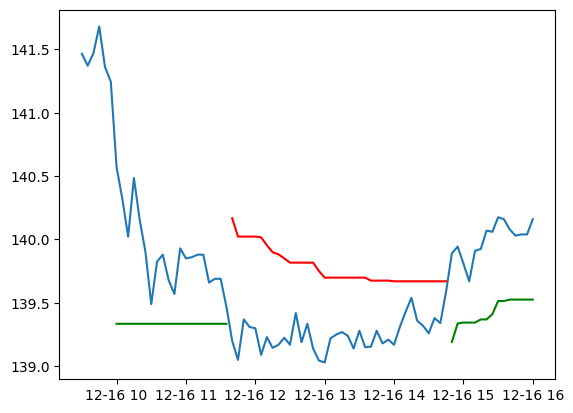

In [54]:
# visualization
plt.plot(df['Close'], label='Close Price')
plt.plot(df['Final Lowerband'], 'g', label = 'Final Lowerband')
plt.plot(df['Final Upperband'], 'r', label = 'Final Upperband')
plt.show()